In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

EMBED_MODEL = "Qwen/Qwen3-Embedding-0.6B"  
MAX_SEQ_CHARS = 3500   
N_CLUSTERS = 10      
TSNE_PERPLEXITY = 30   
TSNE_ITERS = 1000

/people/rachmat/Bureau/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def clean_ws(text: str) -> str:
    return re.sub(r"\s+", " ", (text or "")).strip()

def truncate_context(ctx: str, max_chars: int = MAX_SEQ_CHARS) -> str:
    ctx = clean_ws(ctx)
    if len(ctx) <= max_chars:
        return ctx
    # truncate at a word boundary
    return ctx[:max_chars].rsplit(" ", 1)[0] + " …"

def build_text(title, question, context):
    return f"[TITLE] {clean_ws(title)}\n[QUESTION] {clean_ws(question)}\n[CONTEXT] {truncate_context(context)}"

In [3]:
dataset = load_dataset("rajpurkar/squad_v2")

In [6]:
def split_to_df(ds, split_name):
    rows = []
    for ex in ds:
        has_answer = bool(ex.get("answers", {}).get("text"))
        q = ex["question"]
        c = ex["context"]
        t = ex.get("title", "")
        rows.append({
            "split": split_name,
            "id": ex["id"],
            "title": t,
            "question": q,
            "context": c,
            "has_answer": has_answer,
            "q_len": len(q.split()),
            "c_len": len(c.split())
        })
    return pd.DataFrame(rows)

df_train = split_to_df(dataset["train"], "train")
df_val   = split_to_df(dataset["validation"], "validation")
df = pd.concat([df_train, df_val], ignore_index=True)
print(f"Total samples: {len(df):,}  (train: {len(df_train):,}, val: {len(df_val):,})")

texts = [
    build_text(t, q, c)
    for t, q, c in zip(df["title"], df["question"], df["context"])
]

print("Loading embedding model…")
model = SentenceTransformer(
    EMBED_MODEL,
    tokenizer_kwargs={"padding_side": "left"},
)

model.max_seq_length = 512

print("Encoding texts…")
embeddings = model.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

Total samples: 142,192  (train: 130,319, val: 11,873)
Loading embedding model…
Encoding texts…


Batches:   0%|          | 0/2222 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 47.53 GiB of which 251.94 MiB is free. Process 2445468 has 39.35 GiB memory in use. Including non-PyTorch memory, this process has 7.93 GiB memory in use. Of the allocated memory 7.35 GiB is allocated by PyTorch, and 271.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print("Clustering…")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)

# -------------------
# t-SNE projection
# -------------------
print("t-SNE projection…")
n_samples = embeddings.shape[0]
perp = min(TSNE_PERPLEXITY, max(5, (n_samples - 1) // 3))  # make perplexity safe
tsne = TSNE(n_components=2, random_state=42, perplexity=perp, n_iter=TSNE_ITERS, init="pca")
emb_2d = tsne.fit_transform(embeddings)

# -------------------
# DataFrame with embeddings + clusters
# -------------------
df_plot = df.copy()
df_plot["x"] = emb_2d[:, 0]
df_plot["y"] = emb_2d[:, 1]
df_plot["cluster"] = labels

# Short hover fields
def shorten(s, n=140): 
    s = clean_ws(s)
    return (s if len(s) <= n else s[:n] + "…")

df_plot["hover_title"] = df_plot["title"].apply(shorten)
df_plot["hover_q"] = df_plot["question"].apply(shorten)
df_plot["hover_ctx"] = df_plot["context"].apply(lambda x: shorten(x, 200))

# -------------------
# Plot 1: Interactive t-SNE scatter
# -------------------
fig_scatter = px.scatter(
    df_plot,
    x="x", y="y",
    color="cluster",
    hover_data={"hover_title": True, "hover_q": True, "hover_ctx": True, "q_len": True, "c_len": True, "split": True},
    title=f"SQuAD v2 QA Embeddings (t-SNE) — {N_CLUSTERS} clusters"
)
fig_scatter.update_traces(marker=dict(size=5, opacity=0.8))
fig_scatter.show()

# -------------------
# Plot 2: Cluster size bar chart
# -------------------
size_by_cluster = df_plot.groupby("cluster")["id"].count().reset_index().rename(columns={"id": "count"})
fig_sizes = px.bar(
    size_by_cluster.sort_values("count", ascending=False),
    x="cluster", y="count",
    title="Cluster Sizes (QA pairs per cluster)",
    text="count"
)
fig_sizes.update_traces(textposition="outside")
fig_sizes.show()

# -------------------
# Plot 3: Question length by cluster (box plot)
# -------------------
fig_qbox = px.box(
    df_plot,
    x="cluster", y="q_len",
    title="Question Length by Cluster (words)"
)
fig_qbox.show()

# -------------------
# Plot 4: Has-answer ratio by cluster (stacked bar)
# -------------------
ratio = (
    df_plot.groupby(["cluster", "has_answer"]).size().reset_index(name="count")
)
# pivot to compute percentages
totals = ratio.groupby("cluster")["count"].transform("sum")
ratio["pct"] = ratio["count"] / totals

fig_ratio = px.bar(
    ratio,
    x="cluster",
    y="pct",
    color="has_answer",
    title="Has-Answer Ratio by Cluster",
    barmode="stack",
    labels={"pct": "percentage", "has_answer": "Has answer?"}
)
fig_ratio.update_layout(yaxis_tickformat=".0%")
fig_ratio.show()

# -------------------
# Quick descriptive stats (printed)
# -------------------
print("\n=== Basic stats ===")
print(df_plot[["q_len", "c_len"]].describe().round(2))
print("\nTop 10 clusters by size:")
print(size_by_cluster.sort_values("count", ascending=False).head(10))


In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# -------------------
# Load SQuAD v2
# -------------------
dataset = load_dataset("squad_v2")

# Collect all unique titles
train_titles = list(dataset["train"]["title"])
val_titles = list(dataset["validation"]["title"])
titles = list(set(train_titles + val_titles))
print(f"Total unique titles: {len(titles)}")

# -------------------
# Encode with embeddings
# -------------------
model = SentenceTransformer(
    "Qwen/Qwen3-Embedding-0.6B",
    model_kwargs={"attn_implementation": "flash_attention_2", "device_map": "auto"},
    tokenizer_kwargs={"padding_side": "left"},
)


 embeddings = model.encode(titles, show_progress_bar=True)

# -------------------
# Cluster with KMeans
# -------------------
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)

# -------------------
# Dimensionality reduction (t-SNE)
# -------------------
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
emb_2d = tsne.fit_transform(embeddings)

# -------------------
# Create DataFrame
# -------------------
df = pd.DataFrame({
    "title": titles,
    "x": emb_2d[:, 0],
    "y": emb_2d[:, 1],
    "cluster": labels
})

# -------------------
# Interactive plot with Plotly
# -------------------
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="cluster",
    hover_data=["title"],   # shows title on hover
    title="SQuAD v2 Titles - Interactive Cluster Plot"
)

fig.show()


/people/rachmat/Bureau/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total unique titles: 477


Batches: 100%|██████████| 15/15 [00:00<00:00, 29.80it/s]
/people/rachmat/Bureau/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [2]:
# SQuAD 2.0

ds = load_dataset("squad_v2")  

def hf_squad_to_df(hf_split):
    rows = []
    for ex in hf_split:
        answers = ex.get("answers", {})
        texts = answers.get("text", []) or []
        starts = answers.get("answer_start", []) or []

        first_answer_text = texts[0] if len(texts) > 0 else ""
        first_answer_start = starts[0] if len(starts) > 0 else -1

        rows.append({
            "id": ex.get("id", ""),
            "title": ex.get("title", ""),
            "context": ex.get("context", ""),
            "question": ex.get("question", ""),
            "answer": first_answer_text,          
            "answer_start": first_answer_start,    
        })
    return pd.DataFrame(rows)

df_squad_train = hf_squad_to_df(ds["train"])
df_squad_val = hf_squad_to_df(ds["validation"])

In [3]:
# Covid 19 QA

def open_json(path):
    with open(path, 'r') as f:
        return json.load(f)
    
data_covidqa = open_json('data/covidqa/train.json')

rows = []
for entry in data_covidqa['data']:
    for para in entry['paragraphs']:
        for qa in para['qas']:
            row = {
                "question": qa.get("question", ""),
                "answer": [ans.get("text", "") for ans in qa.get("answers", [])][0]
            }
            rows.append(row)

df_covidqa_train = pd.DataFrame(rows)

In [4]:
# PolicyQA

def flatten_policyqa_split(split_obj):
    rows = []
    for entry in split_obj.get("data", []):
        title = entry.get("title", "")
        for para in entry.get("paragraphs", []):
            context = para.get("context", "")
            index = para.get("index", None)
            summary = para.get("summary", [])
            for qa in para.get("qas", []):
                answers = qa.get("answers", [])
                first_answer_text = answers[0].get("text", "") if answers else ""
                row = {
                    "title": title,
                    "index": index,
                    "context": context,
                    "summary": summary,
                    "question": qa.get("question", ""),
                    "type": qa.get("type", ""),
                    "id": qa.get("id", ""),
                    "answer": first_answer_text,  
                }
                rows.append(row)
    return rows

data_policyqa_train = open_json('data/policyqa/train.json')
data_policyqa_dev = open_json('data/policyqa/dev.json')
data_policyqa_test = open_json('data/policyqa/test.json')

df_policyqa_train = pd.DataFrame(flatten_policyqa_split(data_policyqa_train))
df_policyqa_dev   = pd.DataFrame(flatten_policyqa_split(data_policyqa_dev))
df_policyqa_test  = pd.DataFrame(flatten_policyqa_split(data_policyqa_test))

In [29]:
covidqa_count = len(df_covidqa_train)

policyqa_counts = {
    "train": len(df_policyqa_train),
    "dev": len(df_policyqa_dev),
    "test": len(df_policyqa_test)
}

squad_counts = {
    "train": len(df_squad_train),
    "validation": len(df_squad_val),
}

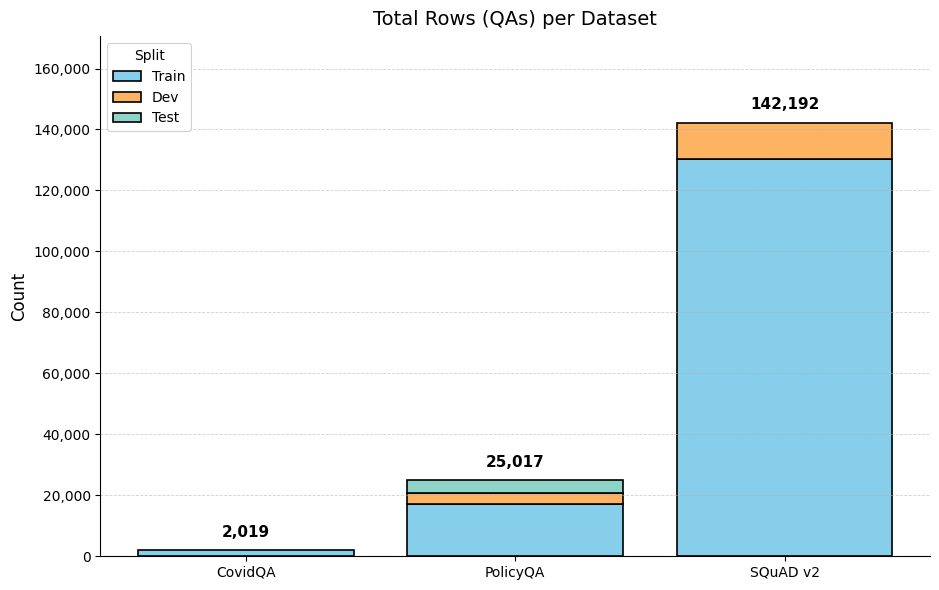

In [ ]:
train_color = "skyblue"
dev_color   = "#FDB462"
test_color  = "#8DD3C7"

covidqa_count   = len(df_covidqa_train)
policyqa_total  = sum(policyqa_counts.values())
squad_total     = sum(squad_counts.values())
ymax            = max(covidqa_count, policyqa_total, squad_total)
ymax            = ymax * 1.2 if ymax > 0 else 1

# --- Start figure ---
fig, ax = plt.subplots(figsize=(9.5, 6))

# 1) CovidQA: single bar
ax.bar("CovidQA", covidqa_count, edgecolor="black", linewidth=1.2, color=train_color)

# label on top
ax.text("CovidQA", covidqa_count + ymax * 0.02, f"{covidqa_count:,}",
        ha="center", va="bottom", fontsize=11, fontweight="bold")

# 2) PolicyQA: stacked (train/dev/test)
bottom = 0
for split_name, color in [("train", train_color), ("dev", dev_color), ("test", test_color)]:
    value = policyqa_counts.get(split_name, 0)
    ax.bar("PolicyQA", value, bottom=bottom, edgecolor="black", linewidth=1.2, color=color,
           label=split_name.capitalize())
    bottom += value

ax.text("PolicyQA", policyqa_total + ymax * 0.02, f"{policyqa_total:,}",
        ha="center", va="bottom", fontsize=11, fontweight="bold")

# 3) SQuAD v2: stacked (train/dev)
bottom = 0
for split_name, color in [("train", train_color), ("validation", dev_color)]:
    value = squad_counts.get(split_name, 0)
    ax.bar("SQuAD v2", value, bottom=bottom, edgecolor="black", linewidth=1.2, color=color,
           label=("Dev" if split_name == "validation" else "Train"))
    bottom += value

ax.text("SQuAD v2", squad_total + ymax * 0.02, f"{squad_total:,}",
        ha="center", va="bottom", fontsize=11, fontweight="bold")

# --- Axes/formatting ---
ax.set_title("Total Rows (QAs) per Dataset", fontsize=14, pad=8)
ax.set_xlabel("")
ax.set_ylabel("Count", fontsize=12)
ax.set_ylim(0, ymax)
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(x):,}")
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# --- Legend (deduplicate labels) ---
handles, labels = ax.get_legend_handles_labels()
dedup = {}
for h, l in zip(handles, labels):
    if l not in dedup:
        dedup[l] = h
leg = ax.legend(dedup.values(), dedup.keys(), title="Split", frameon=True, fancybox=True, framealpha=0.9)
if leg and leg.get_frame():
    leg.get_frame().set_linewidth(0.8)

plt.tight_layout()
plt.show()

In [ ]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

qa_path = 'TechQA/technote_corpus/training_and_dev/training_Q_A.json'
doc_path = 'TechQA/technote_corpus/training_and_dev/training_dev_technotes.json'

def safe_int(x):
    try:
        return int(x)
    except (TypeError, ValueError):
        return -1

# ---------- Load data ----------
with open(qa_path, 'r', encoding='utf-8') as f:
    qa_data = json.load(f)

with open(doc_path, 'r', encoding='utf-8') as f:
    doc_data = json.load(f)

In [ ]:
records = []

for q in qa_data:
    question_text = q.get('QUESTION_TEXT', '').strip()
    answer_text = q.get('ANSWER', '').strip()
    passage_id = q.get('DOCUMENT', '').strip()
    passage_entry = doc_data.get(passage_id, {})

    passage_title = passage_entry.get('title', '').strip()
    passage_text = passage_entry.get('text') or passage_entry.get('content', '')
    
    start_offset = safe_int(q.get('START_OFFSET'))
    end_offset = safe_int(q.get('END_OFFSET'))
    
    answerable = int(q.get('ANSWERABLE', '').strip().upper() == 'Y')
    
    records.append({
        "context": passage_text,
        "question": question_text,
        "answer": answer_text,
        "answer_start": start_offset,
        "answer_end": end_offset,
        "answerable": answerable,
        "dataset": "techqa"
    })

df = pd.DataFrame(records)

In [14]:
df

,question,answer,passage,start_offset,end_offset,answerable
0,Have you found that after upgrade to Streams 4...,"To work around the issue, set environment vari...",FLASH (ALERT)\n\nABSTRACT\n In Streams 4.1.1....,822,1055,1
1,Netcool/Impact (all versions)\n\nUsing the Exi...,This is because the Exit() parser function in ...,netcool; impact; netcool/impact; nci; ipl; pol...,494,763,1
2,I have changed my cluster receiver to match th...,-,,-1,-1,0
3,We are running IHS v7 and our application team...,The following steps help guide you through the...,ssl; handshake; secure socket layer; handshake...,649,1322,1
4,I need to understand details regarding Action ...,-,,-1,-1,0
...,...,...,...,...,...,...
595,I am looking to setup a DataPower MQ Client to...,The following three steps are necessary to mak...,datapower; mq; websphere mq; ssl; mutual authe...,1533,2320,1
596,We have an MQ agent instance that keeps shutti...,Download RELEASE DATE LANGUAGE SIZE(Bytes) Dow...,DOWNLOADABLE FILES\n\nABSTRACT\n This is the ...,1761,1954,1
597,How do I change the default 'fit content by' b...,In the ..navigator.war/applets/filenetViewer_p...,fit by height; fit by width; fit; default fit;...,287,841,1
598,We are using Lombardi 7.2.0.5 version. We are ...,The following table provides direct links to t...,DSREntry; SystemRequirementsDocument; prereq; ...,758,1111,1


In [16]:
# ---------- Compute dataset‑level statistics ----------
stats = {
    "dataset": ["training"],
    "num_questions": [len(df)],
    "avg_question_len": [df["question"].str.len().mean()],
    "avg_answer_len": [df["answer"].str.len().mean()],
    "avg_passage_len": [df["passage"].str.len().mean()],
    "pct_answerable": [df["answerable"].mean() * 100.0]
}
stats_df = pd.DataFrame(stats)


stats_df

,dataset,num_questions,avg_question_len,avg_answer_len,avg_passage_len,pct_answerable
0,training,600,269.86,270.095,3888.378333,75.0
